<a href="https://colab.research.google.com/github/hyanquiv/cnn-tests/blob/master/simpsons_minist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!unzip /content/dataset.zip -d /content

Archive:  /content/dataset.zip
replace /content/dataset/test/bart_simpson/pic_0016.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
# ================================================================================
# CNN PARA CLASIFICACIÓN DE PERSONAJES DE LOS SIMPSON
# ================================================================================

# 1. INSTALACIÓN E IMPORTACIÓN DE LIBRERÍAS
# ================================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid

# Sklearn para métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Verificar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Dispositivo utilizado: cuda
GPU: Tesla T4
Memoria GPU disponible: 14.7 GB


In [48]:
# ================================================================================
# 2. EXPLORACIÓN Y ANÁLISIS DEL DATASET
# ================================================================================

def explore_dataset(data_path):
    """Explora la estructura del dataset y muestra estadísticas"""
    print("=" * 60)
    print("EXPLORACIÓN DEL DATASET")
    print("=" * 60)

    # Obtener clases (personajes)
    classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    print(f"Número de clases (personajes): {len(classes)}")
    print(f"Clases encontradas: {classes}")

    # Contar imágenes por clase
    class_counts = {}
    total_images = 0

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
        total_images += len(image_files)

    print(f"\nTotal de imágenes: {total_images}")
    print("\nDistribución por clase:")
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {class_name}: {count} imágenes")

    return classes, class_counts

# Explorar datasets
train_classes, train_counts = explore_dataset('/content/dataset/train')
test_classes, test_counts = explore_dataset('/content/dataset/test')

EXPLORACIÓN DEL DATASET
Número de clases (personajes): 10
Clases encontradas: ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']

Total de imágenes: 8000

Distribución por clase:
  bart_simpson: 800 imágenes
  charles_montgomery_burns: 800 imágenes
  homer_simpson: 800 imágenes
  krusty_the_clown: 800 imágenes
  lisa_simpson: 800 imágenes
  marge_simpson: 800 imágenes
  milhouse_van_houten: 800 imágenes
  moe_szyslak: 800 imágenes
  ned_flanders: 800 imágenes
  principal_skinner: 800 imágenes
EXPLORACIÓN DEL DATASET
Número de clases (personajes): 10
Clases encontradas: ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']

Total de imágenes: 2000

Distribución por clase:
  bart_simpson: 200 imágenes
  charles_montgo

In [49]:
# ================================================================================
# 3. DEFINICIÓN DE TRANSFORMACIONES Y DATASETS
# ================================================================================

# Transformaciones para entrenamiento (con data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar a tamaño fijo
    transforms.RandomHorizontalFlip(p=0.5),  # Volteo horizontal aleatorio
    transforms.RandomRotation(10),  # Rotación aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variación de color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Traslación aleatoria
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización ImageNet
])

# Transformaciones para validación/test (sin augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = datasets.ImageFolder('/content/dataset/train', transform=train_transforms)
test_dataset = datasets.ImageFolder('/content/dataset/test', transform=test_transforms)

# Información de clases
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Número de clases: {num_classes}")
print(f"Nombres de clases: {class_names}")

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Batches de entrenamiento: {len(train_loader)}")
print(f"Batches de test: {len(test_loader)}")

Número de clases: 10
Nombres de clases: ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']
Batches de entrenamiento: 250
Batches de test: 63


Muestras del dataset de entrenamiento:


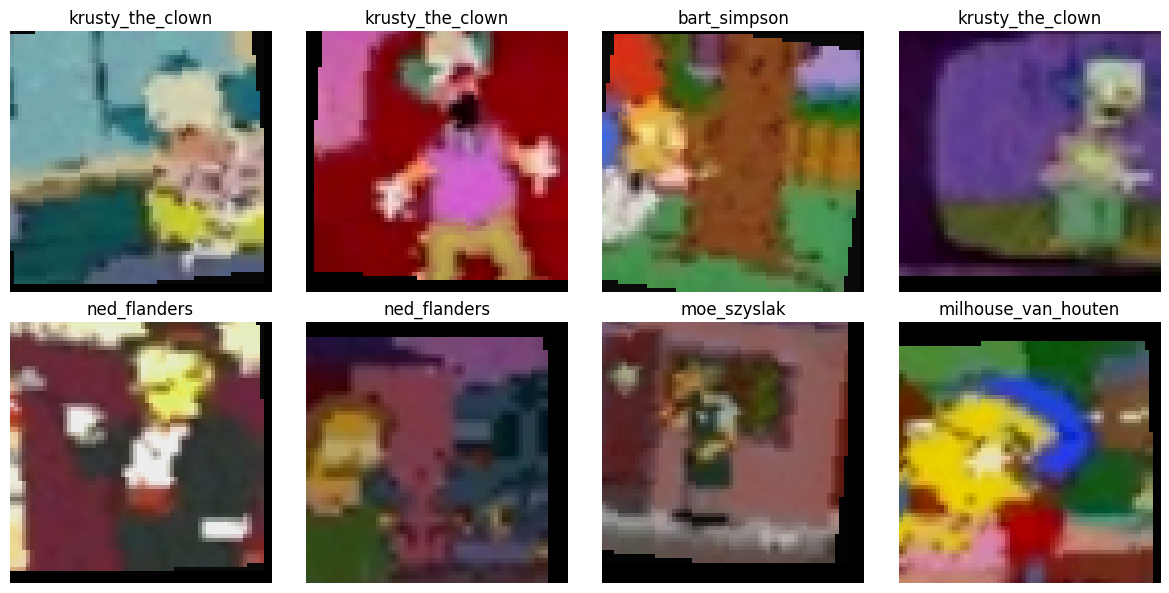

In [50]:
# ================================================================================
# 4. VISUALIZACIÓN DE MUESTRAS DEL DATASET
# ================================================================================

def show_sample_images(loader, class_names, num_samples=8):
    """Muestra imágenes de muestra del dataset"""
    # Obtener un batch
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Desnormalizar para visualización
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images_denorm = images * std + mean
    images_denorm = torch.clamp(images_denorm, 0, 1)

    # Crear grid
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        img = images_denorm[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'{class_names[labels[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Muestras del dataset de entrenamiento:")
show_sample_images(train_loader, class_names)

In [51]:
# ================================================================================
# 5. DEFINICIÓN DE LA ARQUITECTURA CNN
# ================================================================================

class SimpsonCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpsonCNN, self).__init__()

        # Bloque convolucional 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Bloque convolucional 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Bloque convolucional 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)

        # Capas densas
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Bloque 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Bloque 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Bloque 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Aplanar
        x = x.view(x.size(0), -1)

        # Capas densas
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

# Crear modelo
model = SimpsonCNN(num_classes).to(device)

# Resumen del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Número de parámetros entrenables: {count_parameters(model):,}")

Número de parámetros entrenables: 4,618,154


In [52]:
# ================================================================================
# 6. CONFIGURACIÓN DEL ENTRENAMIENTO
# ================================================================================

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler para ajustar learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5,
                                               factor=0.5, verbose=True)

# Función para calcular accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# ================================================================================
# 7. FUNCIONES DE ENTRENAMIENTO Y VALIDACIÓN
# ================================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item() * data.size(0)
        running_accuracy += calculate_accuracy(output, target) * data.size(0)
        total_samples += data.size(0)

        # Progreso
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples

    return epoch_loss, epoch_accuracy

def validate_epoch(model, test_loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item() * data.size(0)
            running_accuracy += calculate_accuracy(output, target) * data.size(0)
            total_samples += data.size(0)

            # Guardar predicciones para métricas
            _, predicted = torch.max(output.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_accuracy / total_samples

    return epoch_loss, epoch_accuracy, all_predictions, all_targets

In [53]:
# ================================================================================
# 8. ENTRENAMIENTO DEL MODELO
# ================================================================================

num_epochs = 30
best_accuracy = 0.0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("=" * 60)
print("INICIANDO ENTRENAMIENTO")
print("=" * 60)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validación
    val_loss, val_acc, val_predictions, val_targets = validate_epoch(model, test_loader, criterion, device)

    # Scheduler step
    scheduler.step(val_loss)

    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Guardar mejor modelo
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_simpson_cnn.pth')
        print(f'Nuevo mejor modelo guardado con accuracy: {best_accuracy:.4f}')

print(f"\nEntrenamiento completado. Mejor accuracy de validación: {best_accuracy:.4f}")

INICIANDO ENTRENAMIENTO

Epoch 1/30
------------------------------
Batch 0/250, Loss: 2.4269
Batch 50/250, Loss: 2.3541
Batch 100/250, Loss: 2.2222
Batch 150/250, Loss: 2.0057
Batch 200/250, Loss: 2.0237
Train Loss: 2.0768, Train Acc: 0.2654
Val Loss: 1.6075, Val Acc: 0.4645
Nuevo mejor modelo guardado con accuracy: 0.4645

Epoch 2/30
------------------------------
Batch 0/250, Loss: 1.8898
Batch 50/250, Loss: 1.6636
Batch 100/250, Loss: 1.8380
Batch 150/250, Loss: 1.5549
Batch 200/250, Loss: 1.9877
Train Loss: 1.7966, Train Acc: 0.3816
Val Loss: 1.3990, Val Acc: 0.5410
Nuevo mejor modelo guardado con accuracy: 0.5410

Epoch 3/30
------------------------------
Batch 0/250, Loss: 1.7615
Batch 50/250, Loss: 1.7882
Batch 100/250, Loss: 1.8368
Batch 150/250, Loss: 1.3542
Batch 200/250, Loss: 1.6568
Train Loss: 1.6537, Train Acc: 0.4392
Val Loss: 1.2527, Val Acc: 0.5860
Nuevo mejor modelo guardado con accuracy: 0.5860

Epoch 4/30
------------------------------
Batch 0/250, Loss: 1.6908
Batc

In [54]:
# ================================================================================
# 9. CÁLCULO DE MÉTRICAS FINALES
# ================================================================================

# Cargar mejor modelo
model.load_state_dict(torch.load('best_simpson_cnn.pth'))

# Evaluación final
print("=" * 60)
print("EVALUACIÓN FINAL")
print("=" * 60)

final_loss, final_accuracy, final_predictions, final_targets = validate_epoch(
    model, test_loader, criterion, device)

# Calcular métricas detalladas
precision, recall, f1, support = precision_recall_fscore_support(
    final_targets, final_predictions, average=None, labels=range(num_classes))

# Métricas promedio
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

print(f"Accuracy Final: {final_accuracy:.4f}")
print(f"Precision Promedio: {avg_precision:.4f}")
print(f"Recall Promedio: {avg_recall:.4f}")
print(f"F1-Score Promedio: {avg_f1:.4f}")

# Reporte detallado por clase
print("\nReporte detallado por clase:")
print(classification_report(final_targets, final_predictions,
                          target_names=class_names, digits=4))

EVALUACIÓN FINAL
Accuracy Final: 0.8515
Precision Promedio: 0.8556
Recall Promedio: 0.8515
F1-Score Promedio: 0.8515

Reporte detallado por clase:
                          precision    recall  f1-score   support

            bart_simpson     0.7760    0.7100    0.7415       200
charles_montgomery_burns     0.7100    0.8200    0.7610       200
           homer_simpson     0.8951    0.7250    0.8011       200
        krusty_the_clown     0.9455    0.9550    0.9502       200
            lisa_simpson     0.7437    0.7400    0.7419       200
           marge_simpson     0.9360    0.9500    0.9429       200
     milhouse_van_houten     0.8654    0.9000    0.8824       200
             moe_szyslak     0.7773    0.8900    0.8298       200
            ned_flanders     0.9391    0.9250    0.9320       200
       principal_skinner     0.9677    0.9000    0.9326       200

                accuracy                         0.8515      2000
               macro avg     0.8556    0.8515    0.8515    

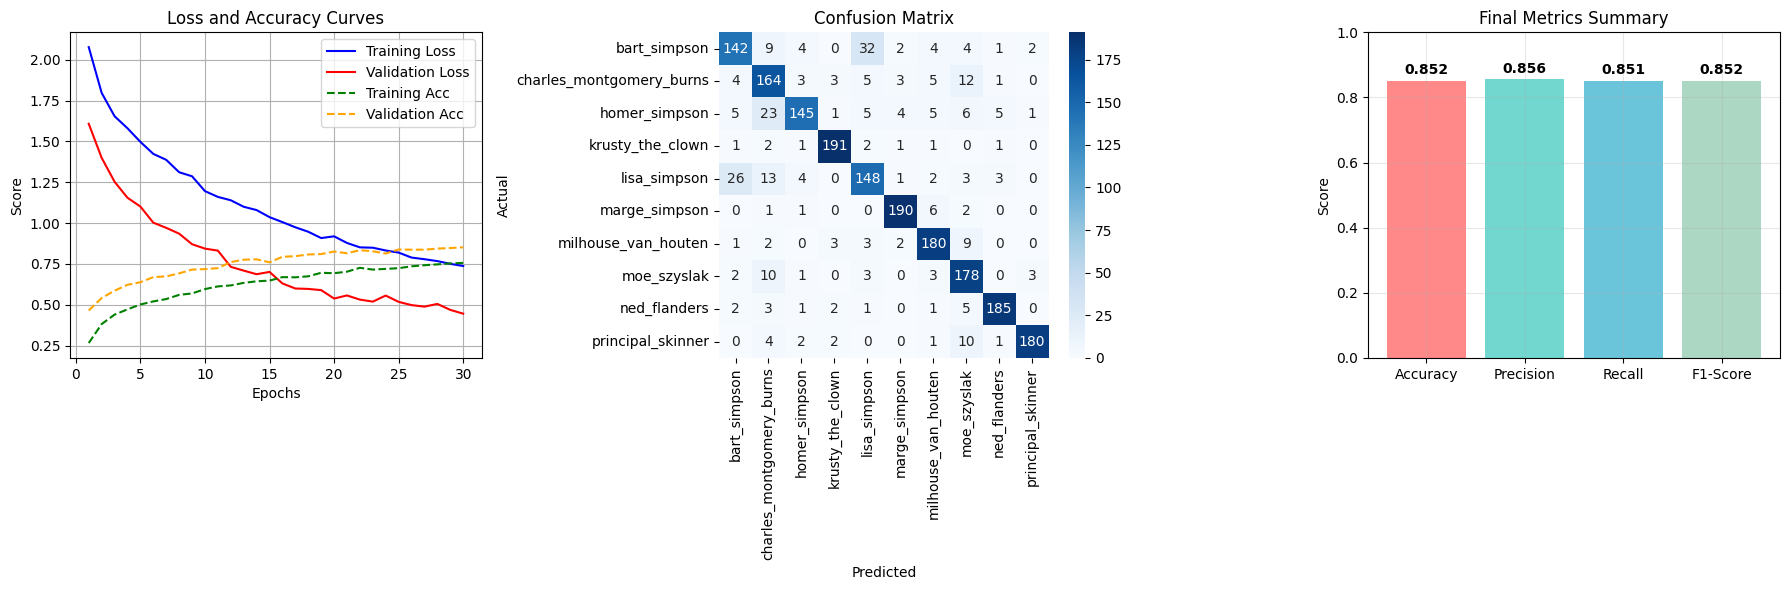

In [57]:
# ================================================================================
# VISUALIZACION DE CURVAS, MATRIZ Y METRICAS FINALES
# ================================================================================

fig = plt.figure(figsize=(18, 6))

# 1. Curvas de entrenamiento (loss y accuracy)
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
plt.plot(epochs_range, train_accuracies, label='Training Acc', color='green', linestyle='--')
plt.plot(epochs_range, val_accuracies, label='Validation Acc', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Loss and Accuracy Curves')
plt.legend()
plt.grid(True)

# 2. Matriz de confusion
plt.subplot(1, 3, 2)
cm = confusion_matrix(final_targets, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3. Resumen de metricas finales
plt.subplot(1, 3, 3)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [final_accuracy, avg_precision, avg_recall, avg_f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics_names, metrics_values, color=colors, alpha=0.8)
plt.ylabel('Score')
plt.title('Final Metrics Summary')
plt.ylim(0, 1)
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
# ================================================================================
# 11. RESUMEN FINAL
# ================================================================================

print("=" * 80)
print("RESUMEN FINAL DEL ENTRENAMIENTO")
print("=" * 80)
print(f"Dataset: {len(train_dataset)} imágenes de entrenamiento, {len(test_dataset)} de test")
print(f"Clases: {num_classes} personajes de Los Simpson")
print(f"Arquitectura: CNN con {count_parameters(model):,} parámetros")
print(f"Epochs entrenados: {num_epochs}")
print(f"Mejor accuracy de validación: {best_accuracy:.4f}")
print("\nMétricas finales:")
print(f"  • Accuracy: {final_accuracy:.4f}")
print(f"  • Precision: {avg_precision:.4f}")
print(f"  • Recall: {avg_recall:.4f}")
print(f"  • F1-Score: {avg_f1:.4f}")
print("=" * 80)

# Crear DataFrame con métricas por clase para análisis posterior
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nMétricas detalladas por clase:")
print(metrics_df.round(4))

# Guardar métricas en CSV
metrics_df.to_csv('simpson_cnn_metrics.csv', index=False)
print("\nMétricas guardadas en 'simpson_cnn_metrics.csv'")
print("Modelo guardado en 'best_simpson_cnn.pth'")

RESUMEN FINAL DEL ENTRENAMIENTO
Dataset: 8000 imágenes de entrenamiento, 2000 de test
Clases: 10 personajes de Los Simpson
Arquitectura: CNN con 4,618,154 parámetros
Epochs entrenados: 30
Mejor accuracy de validación: 0.8515

Métricas finales:
  • Accuracy: 0.8515
  • Precision: 0.8556
  • Recall: 0.8515
  • F1-Score: 0.8515

Métricas detalladas por clase:
                      Class  Precision  Recall  F1-Score  Support
0              bart_simpson     0.7760   0.710    0.7415      200
1  charles_montgomery_burns     0.7100   0.820    0.7610      200
2             homer_simpson     0.8951   0.725    0.8011      200
3          krusty_the_clown     0.9455   0.955    0.9502      200
4              lisa_simpson     0.7437   0.740    0.7419      200
5             marge_simpson     0.9360   0.950    0.9429      200
6       milhouse_van_houten     0.8654   0.900    0.8824      200
7               moe_szyslak     0.7773   0.890    0.8298      200
8              ned_flanders     0.9391   0.925 